In [1]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
     |████████████████████████████████| 703.8MB 27kB/s 
     |████████████████████████████████| 6.6MB 44.8MB/s 
  Found existing installation: torch 1.5.1+cu101
    Uninstalling torch-1.5.1+cu101:
      Successfully uninstalled torch-1.5.1+cu101
  Found existing installation: torchvision 0.6.1+cu101
    Uninstalling torchvision-0.6.1+cu101:
      Successfully uninstalled torchvision-0.6.1+cu101
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-wvexu8yp
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-wvexu8yp
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=266987 sha256=dd22bf5a15957794bd377bf01882873c0fb198569b5e238189c12fb7a325215d
  Stored in directory: /tmp/pip-ephem-wheel-cache-cxwi2pcv/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existi

In [2]:
# mount your gdrive folder
from google.colab import drive
drive.mount('/content/drive')



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
%cd /content/drive/My Drive/ML


/content/drive/My Drive/ML


In [4]:
# install detectron2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
     |████████████████████████████████| 6.2MB 787kB/s 
  Created wheel for fvcore: filename=fvcore-0.1.1.post20200711-cp36-none-any.whl size=42285 sha256=db2395f85c95c8be4775240dd81e419d7a2f0ef71729babcce35856b9a19a921
  Stored in directory: /root/.cache/pip/wheels/be/e2/ff/183aa84c45c7f0a6f55d2a40bdbfc00e9d5c36b492065ec526
Successfully built fvcore


In [5]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger

import detectron2
from detectron2.utils.logger import setup_logger
#setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog


In [6]:

# Register a dataset in COCO’s json annotation format for instance detection, instance segmentation and keypoint detection. 
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/drive/My Drive/ML/new_annotations/train/train_coco.json", "/content/drive/My Drive/ML/new_annotations/train/images")
register_coco_instances("my_dataset_val", {}, "/content/drive/My Drive/ML/new_annotations/val/val_coco.json", "/content/drive/My Drive/ML/new_annotations/val/images")


In [7]:
from detectron2.data import DatasetCatalog, MetadataCatalog

papers_metadata = MetadataCatalog.get("my_dataset_train") #return the Metadata instance associated with this name
dataset_dicts = DatasetCatalog.get("my_dataset_train") # Call the registered function and return dataset annotations


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



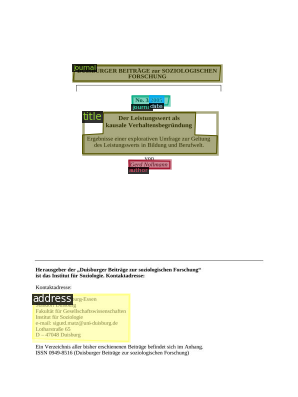

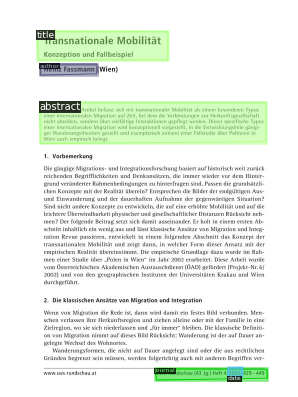

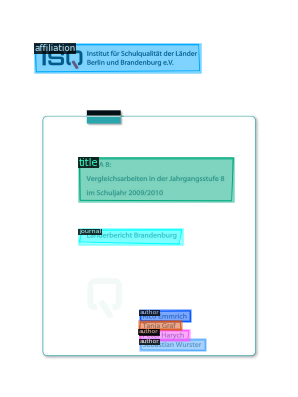

In [8]:
# take a look at the data to see if the images are loaded correctly
from google.colab.patches import cv2_imshow
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=papers_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [9]:
import os
import datetime
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

# create the output dir for the trained model
output_dir = os.path.join("/content/drive/My Drive/ML/output", datetime.datetime.now().strftime('%Y%m%dT%H%M'))
os.makedirs(output_dir, exist_ok=True)
# change the config in the .yaml document
cfg = cfg = get_cfg() #load default config
cfg.merge_from_file("/content/drive/My Drive/ML/detectron2/configs/DLA_mask_rcnn_X_101_32x8d_FPN_3x.yaml")
cfg.OUTPUT_DIR = output_dir #change the output path
cfg.DATASETS.TRAIN = ("my_dataset_train",) #specify the trainning dataset
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "/content/drive/My Drive/ML/model_final_trimmed.pth"  # load intial weights from the pre-trained model in publaynet
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.PANOPTIC_FPN.COMBINE.INSTANCES_CONFIDENCE_THRESH = 0.5
cfg.SOLVER.IMS_PER_BATCH = 2
# cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 5000    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
# cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 9 
cfg.MODEL.BACKBONE.FREEZE_AT= 5 #freeze the stem and 3 backbone layers
#serialize the training config
cfg_str = cfg.dump()
with open(os.path.join(cfg.OUTPUT_DIR, "train_config.yaml"), "w") as f:  #write the new config in the 'train_config.yaml'
  f.write(cfg_str)
f.close()

# using hpanwar08's trainer specified in the cell above
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()



Config '/content/drive/My Drive/ML/detectron2/configs/DLA_mask_rcnn_X_101_32x8d_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


[07/14 14:32:29 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Unable to load 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (6, 1024) in the checkpoint but (10, 1024) in the model!
Unable to load 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (6,) in the checkpoint but (10,) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (20, 1024) in the checkpoint but (36, 1024) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (20,) in the checkpoint but (36,) in the model!
Unable to load 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (5, 256, 1, 1) in the checkpoint but (9, 256, 1, 1) in the model!
Unable to load 'roi_heads.mask_head.predictor.bias' to the model due to incompatible shapes: (5,) in the checkpoint but (9,) in the model!


[07/14 14:32:49 d2.engine.train_loop]: Starting training from iteration 0
[07/14 14:33:22 d2.utils.events]:  eta: 2:15:21  iter: 19  total_loss: 3.676  loss_cls: 2.367  loss_box_reg: 0.150  loss_mask: 0.691  loss_rpn_cls: 0.177  loss_rpn_loc: 0.209  time: 1.5928  data_time: 0.0505  lr: 0.000018  max_mem: 1872M
[07/14 14:33:54 d2.utils.events]:  eta: 2:16:14  iter: 39  total_loss: 3.274  loss_cls: 1.979  loss_box_reg: 0.153  loss_mask: 0.683  loss_rpn_cls: 0.130  loss_rpn_loc: 0.184  time: 1.6102  data_time: 0.0065  lr: 0.000036  max_mem: 1872M
[07/14 14:34:28 d2.utils.events]:  eta: 2:16:21  iter: 59  total_loss: 2.514  loss_cls: 1.329  loss_box_reg: 0.179  loss_mask: 0.665  loss_rpn_cls: 0.183  loss_rpn_loc: 0.163  time: 1.6300  data_time: 0.0066  lr: 0.000054  max_mem: 1872M
[07/14 14:35:00 d2.utils.events]:  eta: 2:15:29  iter: 79  total_loss: 1.713  loss_cls: 0.656  loss_box_reg: 0.139  loss_mask: 0.629  loss_rpn_cls: 0.107  loss_rpn_loc: 0.151  time: 1.6297  data_time: 0.0072  lr:

In [10]:
print(output_dir)

/content/drive/My Drive/ML/output/20200714T1432


In [11]:
import os
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("my_dataset_val", )
predictor = DefaultPredictor(cfg)

[07/14 16:50:19 d2.data.datasets.coco]: Loading /content/drive/My Drive/ML/new_annotations/val/val_coco.json takes 2.25 seconds.
WARNING [07/14 16:50:19 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/14 16:50:19 d2.data.datasets.coco]: Loaded 17 images in COCO format from /content/drive/My Drive/ML/new_annotations/val/val_coco.json


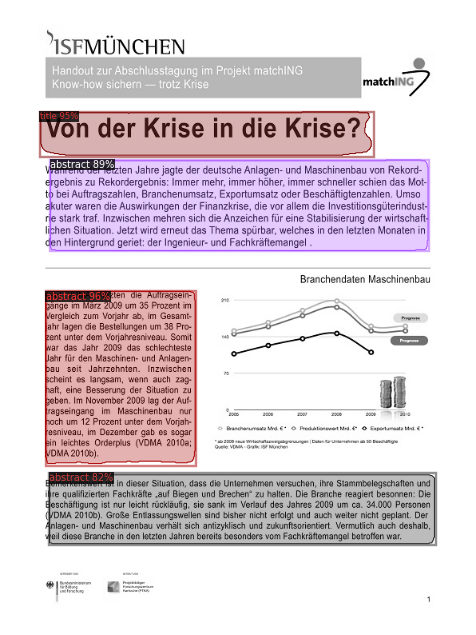

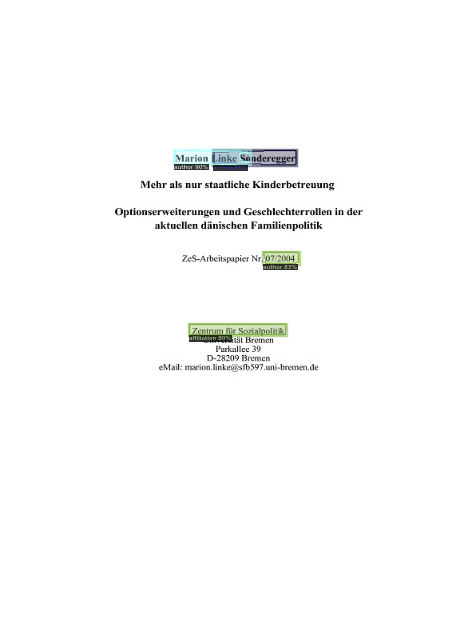

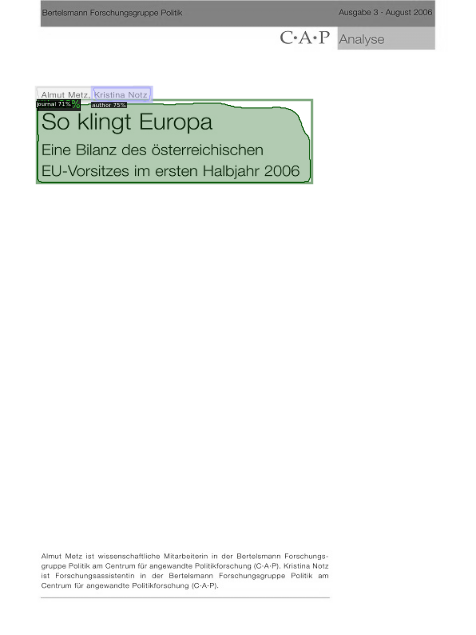

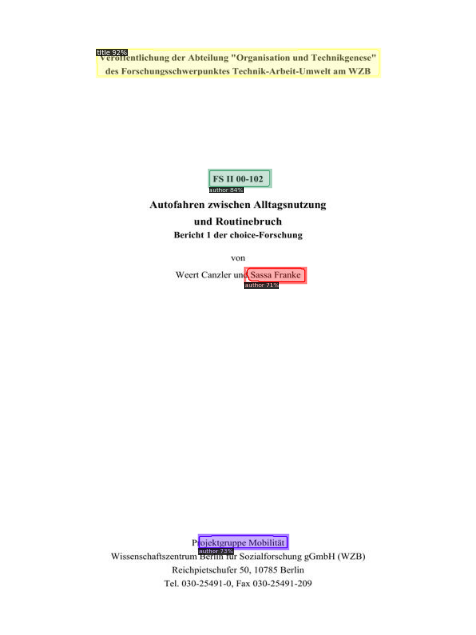

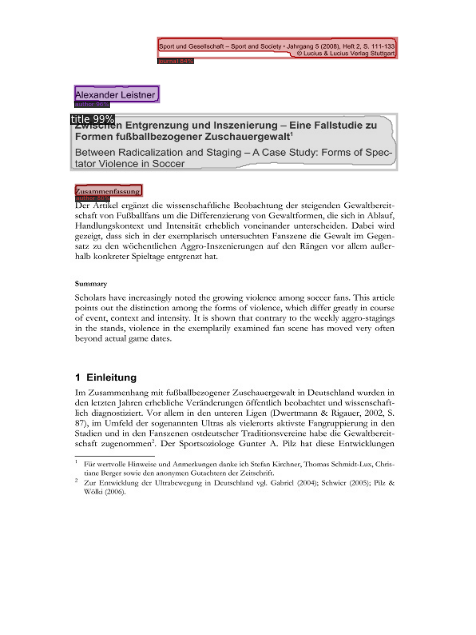

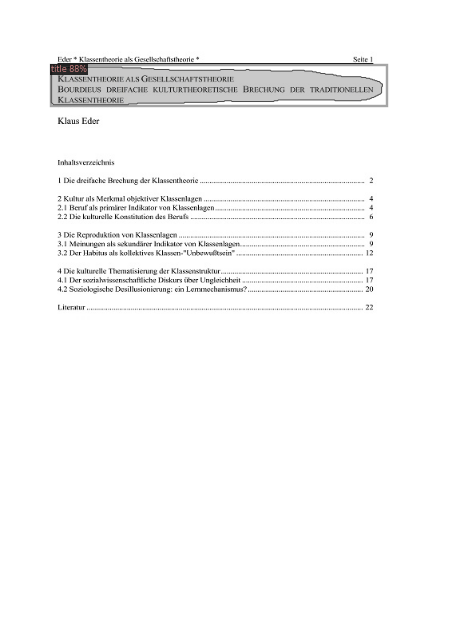

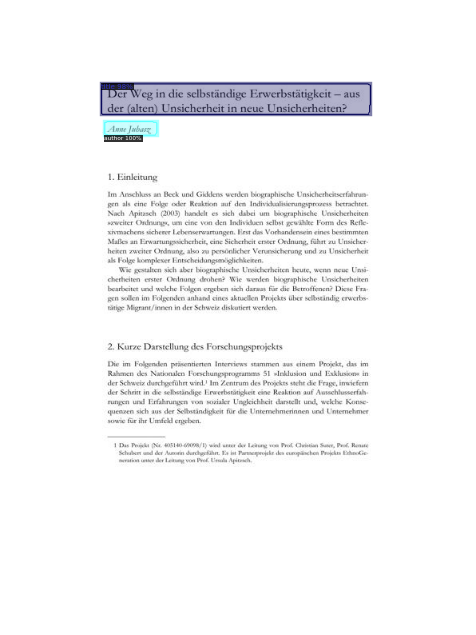

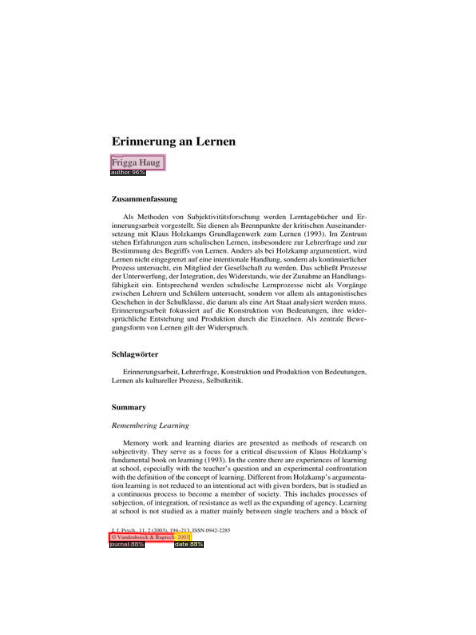

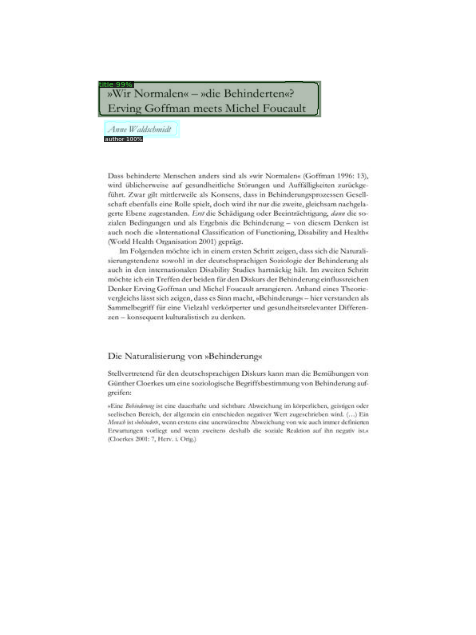

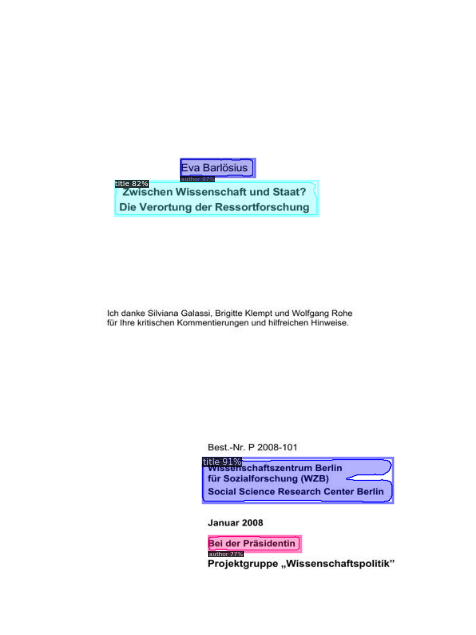

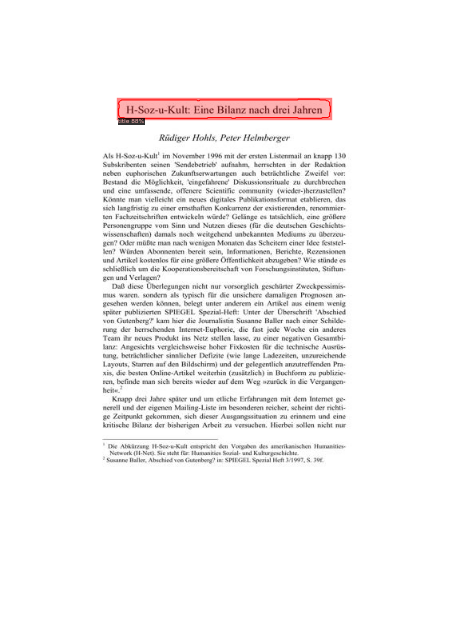

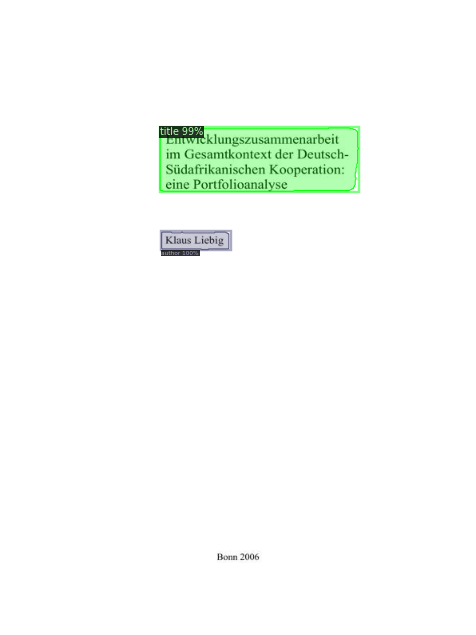

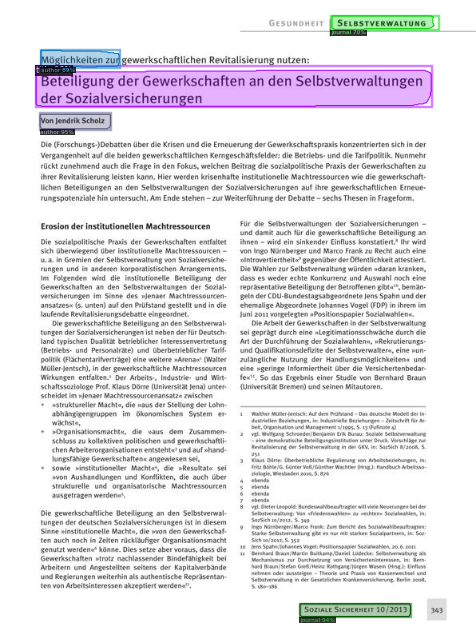

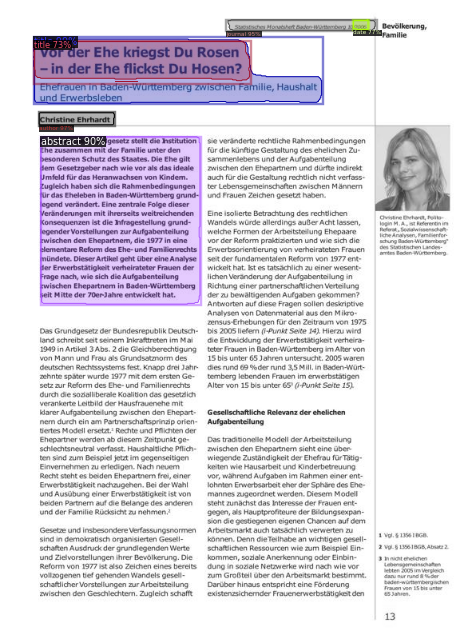

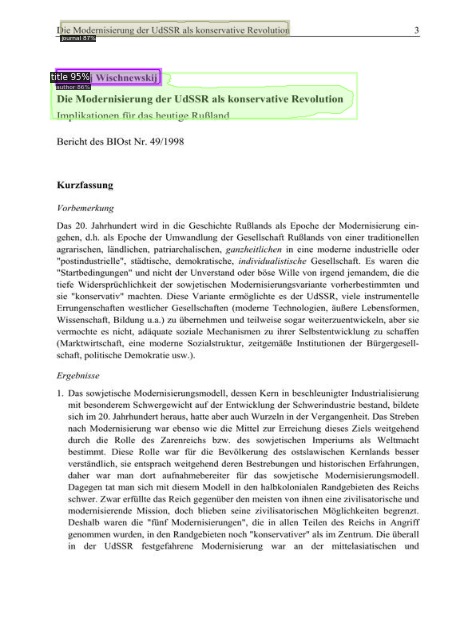

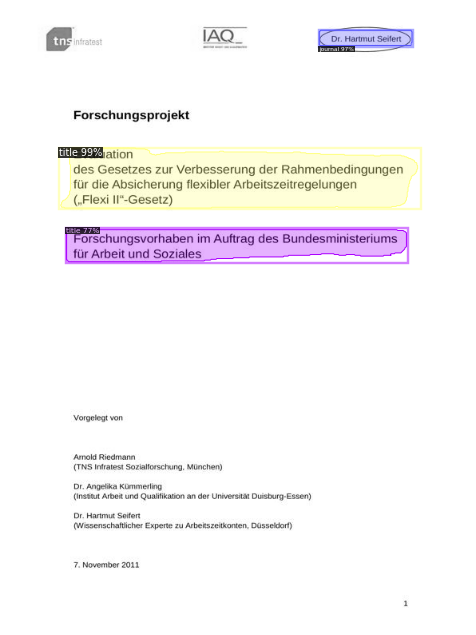

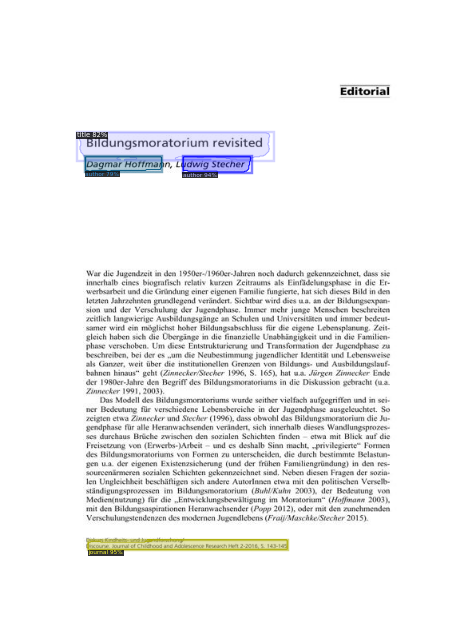

In [12]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts_val = DatasetCatalog.get("my_dataset_val")
for d in dataset_dicts_val:    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=papers_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

In [13]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("my_dataset_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [07/14 16:50:52 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/14 16:50:52 d2.data.datasets.coco]: Loaded 17 images in COCO format from /content/drive/My Drive/ML/new_annotations/val/val_coco.json
[07/14 16:50:52 d2.data.build]: Distribution of instances among all 9 categories:
|  category  | #instances   |  category  | #instances   |  category   | #instances   |
|:----------:|:-------------|:----------:|:-------------|:-----------:|:-------------|
|  abstract  | 6            |  address   | 4            | affiliation | 8            |
|   author   | 22           |    date    | 12           |     doi     | 1            |
|   email    | 1            |  journal   | 7            |    title    | 19           |
|            |              |            |              |             |              |
|   total    | 80           |            |              |             |              |
[07/14 16:50:53 d2.data.common]: 

OrderedDict([('bbox',
              {'AP': 16.330511375781402,
               'AP-abstract': 45.328932893289334,
               'AP-address': 0.0,
               'AP-affiliation': 1.2871287128712867,
               'AP-author': 30.740463308784676,
               'AP-date': 9.084158415841584,
               'AP-doi': 0.0,
               'AP-email': 0.0,
               'AP-journal': 14.990570485619989,
               'AP-title': 45.5433485656258,
               'AP50': 30.957498071846135,
               'AP75': 18.49924308670183,
               'APl': 31.87845799231938,
               'APm': 12.779810908877387,
               'APs': 7.70957095709571}),
             ('segm',
              {'AP': 16.206309073825125,
               'AP-abstract': 45.665566556655676,
               'AP-address': 0.0,
               'AP-affiliation': 1.2871287128712867,
               'AP-author': 32.514656517845516,
               'AP-date': 7.896039603960396,
               'AP-doi': 0.0,
               'AP

In [14]:
#register the test dataset
register_coco_instances("my_dataset_test", {}, "/content/drive/My Drive/ML/new_annotations/test/test_coco.json", "/content/drive/My Drive/ML/new_annotations/test/images")

[07/14 16:51:34 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

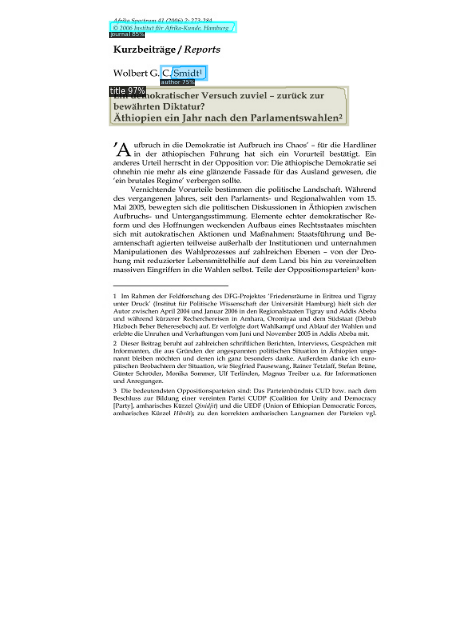

/content/drive/My Drive/ML/new_annotations/test/images/11164


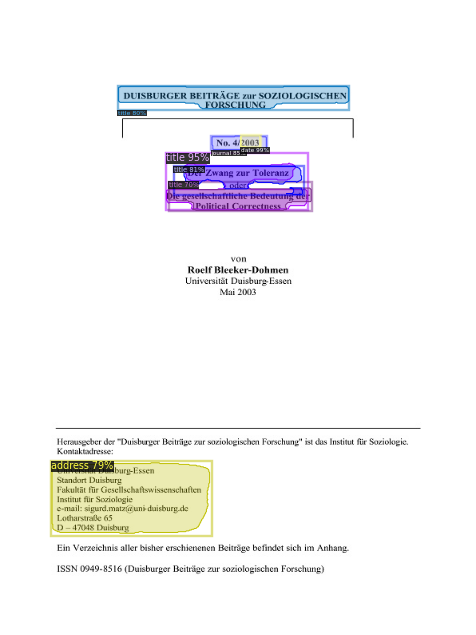

/content/drive/My Drive/ML/new_annotations/test/images/11190


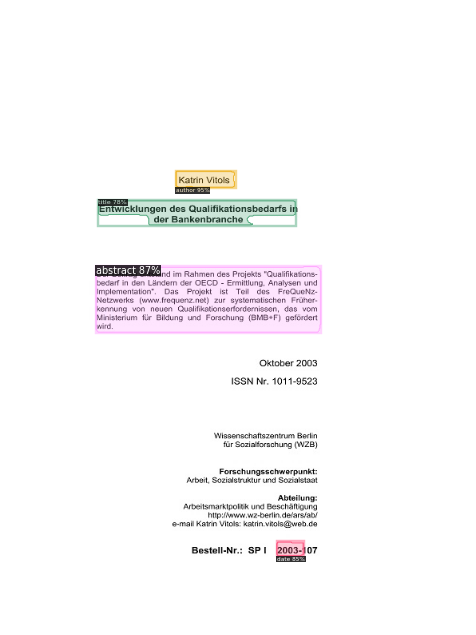

/content/drive/My Drive/ML/new_annotations/test/images/11448


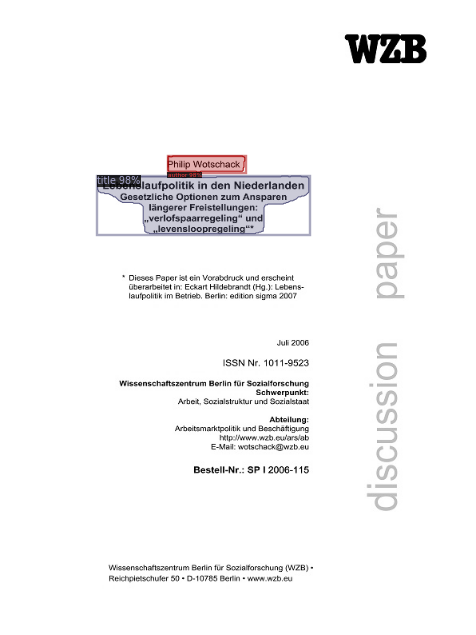

/content/drive/My Drive/ML/new_annotations/test/images/12797


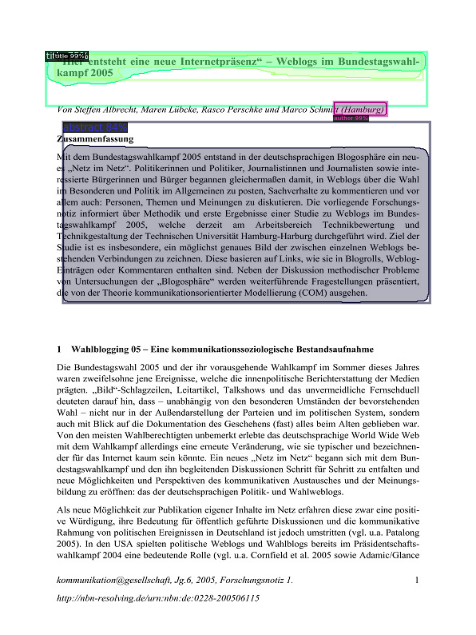

/content/drive/My Drive/ML/new_annotations/test/images/17492


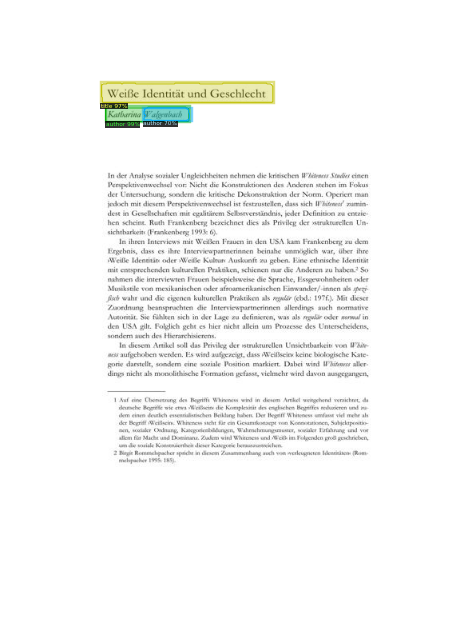

/content/drive/My Drive/ML/new_annotations/test/images/19396


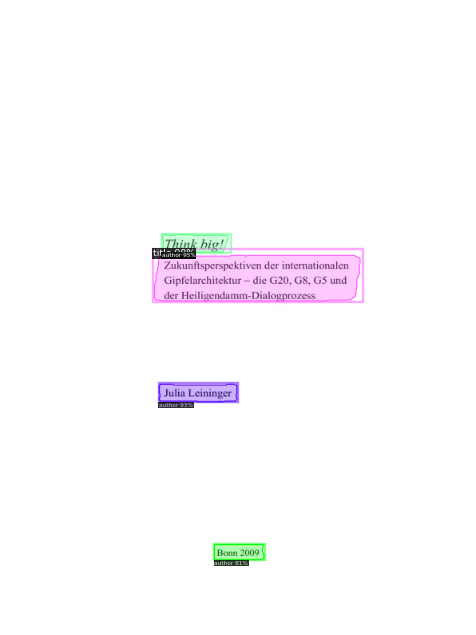

/content/drive/My Drive/ML/new_annotations/test/images/22006


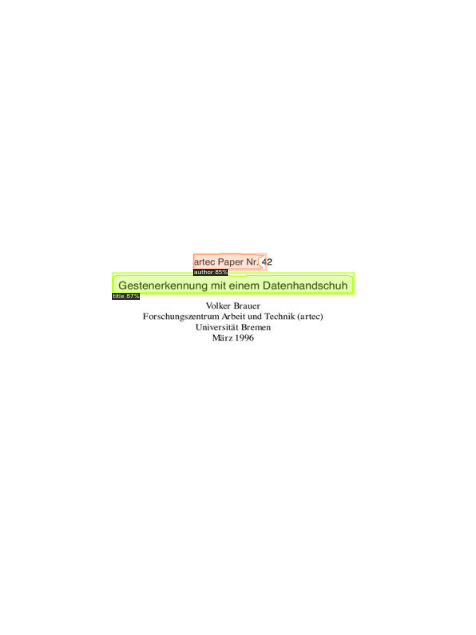

/content/drive/My Drive/ML/new_annotations/test/images/31474


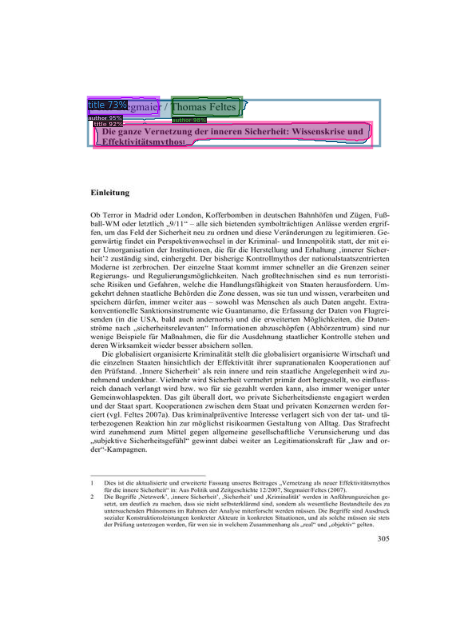

In [15]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)

from detectron2.utils.visualizer import ColorMode
dataset_dicts_test = DatasetCatalog.get("my_dataset_test")
for d in dataset_dicts_test:    
    im = cv2.imread(d["file_name"])
    print(d["file_name"][:-5])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=papers_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2.imwrite(d["file_name"][:-5] + "_test.png", v.get_image()[:, :, ::-1])
    cv2_imshow(v.get_image()[:, :, ::-1])

In [16]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir=output_dir)
val_loader = build_detection_test_loader(cfg, "my_dataset_test")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

WARNING [07/14 16:52:03 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/14 16:52:03 d2.data.datasets.coco]: Loaded 9 images in COCO format from /content/drive/My Drive/ML/new_annotations/test/test_coco.json
[07/14 16:52:03 d2.data.build]: Distribution of instances among all 9 categories:
|  category  | #instances   |  category  | #instances   |  category   | #instances   |
|:----------:|:-------------|:----------:|:-------------|:-----------:|:-------------|
|  abstract  | 1            |  address   | 3            | affiliation | 7            |
|   author   | 13           |    date    | 8            |     doi     | 6            |
|   email    | 2            |  journal   | 3            |    title    | 9            |
|            |              |            |              |             |              |
|   total    | 52           |            |              |             |              |
[07/14 16:52:03 d2.data.common]:

OrderedDict([('bbox',
              {'AP': 16.649795931974147,
               'AP-abstract': 35.0,
               'AP-address': 26.930693069306926,
               'AP-affiliation': 0.0,
               'AP-author': 17.706270627062704,
               'AP-date': 9.009900990099007,
               'AP-doi': 0.0,
               'AP-email': 0.0,
               'AP-journal': 0.0,
               'AP-title': 61.201298701298704,
               'AP50': 25.83258325832583,
               'AP75': 18.437843784378437,
               'APl': 59.58470847084708,
               'APm': 9.89253300330033,
               'APs': 3.927392739273926}),
             ('segm',
              {'AP': 17.84400106677334,
               'AP-abstract': 45.0,
               'AP-address': 30.297029702970292,
               'AP-affiliation': 0.0,
               'AP-author': 21.320132013201317,
               'AP-date': 11.58415841584158,
               'AP-doi': 0.0,
               'AP-email': 0.0,
               'AP-journal': 